### Import packages

In [1]:
library(data.table)
library(Matrix)
library(proxy)
library(Rtsne)
library(densityClust)
library(data.table)
library(irlba)
library(umap)
library(ggplot2)
library(RColorBrewer)


Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix



### Load Data

In [2]:
load('Cusanovich2018_buenrostro2018.RData')

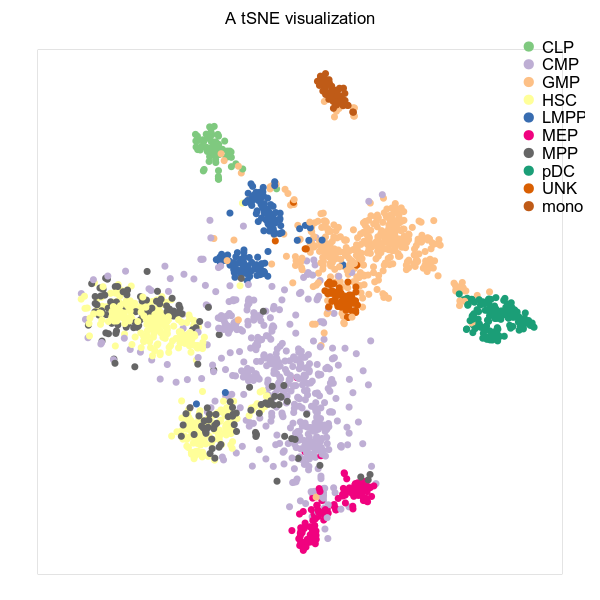

In [3]:
options(repr.plot.width=5, repr.plot.height=5)
plot.tsne(tsnetfidf$Y,as.factor(metadata[,'label']))

### Following tutorial at http://atlas.gs.washington.edu/mouse-atac/docs/

In [4]:
## https://github.com/shendurelab/mouse-atac/blob/master/clustering/clustering.R
library(Seurat) ## conda install -c bioconda r-seurat=2.3.4
library(Matrix)


make_seurat = function(atac_matrix, metadata=NULL, pca_coords=NULL, tsne_coords=NULL) {
               if (is.null(pca_coords) && is.null(tsne_coords)) {
			stop('One of pca_coords or tsne_coords (or both) must be set to make the fake seurat object.')
	       }

               if (!is.null(metadata)) {
                   seurat_obj = CreateSeuratObject(atac_matrix, meta.data=metadata, project='DEFAULT', min.cells=0, min.genes=0)
	       } else {
		   seurat_obj = CreateSeuratObject(atac_matrix, project='DEFAULT', min.cells=0, min.genes=0)
	       }

	       if (!is.null(pca_coords)) {
			pca_coords = as.matrix(pca_coords)
               		seurat_obj <- SetDimReduction(object = seurat_obj, reduction.type = "pca", slot = "cell.embeddings", new.data = pca_coords)
               		seurat_obj <- SetDimReduction(object = seurat_obj, reduction.type = "pca", slot = "key", new.data = "pca")
	       }

	       if (!is.null(tsne_coords)) {
			tsne_coords = as.matrix(tsne_coords)
                        seurat_obj = CreateSeuratObject(atac_matrix, meta.data=metadata, project='DEFAULT', min.cells=0, min.genes=0)
                        seurat_obj <- SetDimReduction(object = seurat_obj, reduction.type = "tsne", slot = "cell.embeddings", new.data = tsne_coords)
                        seurat_obj <- SetDimReduction(object = seurat_obj, reduction.type = "tsne", slot = "key", new.data = "tsne")
	       }

               return(seurat_obj)
}


Loading required package: cowplot

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [5]:
## https://github.com/shendurelab/mouse-atac/blob/master/dim_reduction/dim_reduction.R
library(Matrix)
library(Rtsne)
library(irlba)

atac_dim_reduction = function(atac_matrix, site_frequency_threshold=0.03) {
               num_cells_ncounted = Matrix::rowSums(atac_matrix)
               threshold = ncol(atac_matrix) * site_frequency_threshold

               ncounts = atac_matrix[num_cells_ncounted >= threshold,]

               ## Normalize the data with TF-IDF
               nfreqs = t(t(ncounts) / Matrix::colSums(ncounts))
               tf_idf_counts = nfreqs * log(1 + ncol(ncounts) / Matrix::rowSums(ncounts))

               ## Do SVD
               set.seed(0)
               SVDtsne = irlba(tf_idf_counts, 50, 50, maxit=1000)
               d_diagtsne = matrix(0, nrow=length(SVDtsne$d), ncol=length(SVDtsne$d))
               diag(d_diagtsne) = SVDtsne$d
               SVDtsne_vd = t(d_diagtsne %*% t(SVDtsne$v))
               rownames(SVDtsne_vd) = colnames(atac_matrix)
               colnames(SVDtsne_vd) = paste0('pca_', 1:ncol(SVDtsne_vd))

               ## Run TSNE to 2 dimensions
               tsnetfidf = Rtsne(SVDtsne_vd, pca=F, perplexity=30, max_iter=5000)

               tsne_coords = as.data.frame(tsnetfidf$Y)
               colnames(tsne_coords) = c('tsne_1', 'tsne_2')
               rownames(tsne_coords) = colnames(ncounts)

               return(list('tsne_coords'=tsne_coords, 'pca_coords'=as.data.frame(SVDtsne_vd)))
}

### Dimensionality Reduction 

In [6]:
results.dim_reduction = atac_dim_reduction(binary_mat, site_frequency_threshold=0.02)

### Clustering

In [7]:
# We provide a utility function to take the results from the dimensionality reduction
# performed above and put them in a Seurat object, although this code is simple
# and you may modify it to suit your needs
seurat_obj = make_seurat(binary_mat, tsne_coords=results.dim_reduction$tsne_coords, pca_coords=results.dim_reduction$pca_coords)

In [8]:
# You may then use Seurat as normal with desired parameters for clustering
# for the buenrostro 2018 dataset:
# resolution    # clusters
#       0.8     2
#       1.0     4
#       1.02    8
#       1.025   10
#       1.03    11
#       1.05    24
#       1.1     55
#       1.2     45
seurat_obj = FindClusters(seurat_obj, reduction.type='pca', save.SNN=TRUE, resolution=1.025)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2034
Number of edges: 2007485

Running Louvain algorithm...
Random start: 1
Iteration: 1
Modularity: 0.0040
Iteration: 2
Modularity: 0.0041
Iteration: 3
Modularity: 0.0041

Random start: 2
Iteration: 1
Modularity: 0.0040
Iteration: 2
Modularity: 0.0040
Iteration: 3
Modularity: 0.0040

Random start: 3
Iteration: 1
Modularity: 0.0039
Iteration: 2
Modularity: 0.0039

Random start: 4
Iteration: 1
Modularity: 0.0039
Iteration: 2
Modularity: 0.0040
Iteration: 3
Modularity: 0.0040
Iteration: 4
Modularity: 0.0040

Random start: 5
Iteration: 1
Modularity: 0.0039
Iteration: 2
Modularity: 0.0039
Iteration: 3
Modularity: 0.0039

Random start: 6
Iteration: 1
Modularity: 0.0041
Iteration: 2
Modularity: 0.0041
Iteration: 3
Modularity: 0.0041

Random start: 7
Iteration: 1
Modularity: 0.0038
Iteration: 2
Modularity: 0.0038
Iteration: 3
Modularity: 0.0038

Random start: 8
Iteration: 1
Modularity: 0.0041
Iteration: 

In [9]:
length(levels(as.factor(seurat_obj@ident)))

[1] 10

In [10]:
str(seurat_obj)

Formal class 'seurat' [package "Seurat"] with 20 slots
  ..@ raw.data    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:13634167] 109 308 323 1050 1128 1211 1577 1610 1666 1752 ...
  .. .. ..@ p       : int [1:2035] 0 1858 3234 4572 5903 7473 9675 10747 11814 14346 ...
  .. .. ..@ Dim     : int [1:2] 237450 2034
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:237450] "chr1_10413_10625" "chr1_13380_13624" "chr1_16145_16354" "chr1_96388_96812" ...
  .. .. .. ..$ : chr [1:2034] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14" "BM1077-CLP-Frozen-160106-2" "BM1077-CLP-Frozen-160106-21" ...
  .. .. ..@ x       : num [1:13634167] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..@ factors : list()
  ..@ data        :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:13634167] 109 308 323 1050 1128 1211 1577 1610 1666 1752 ...
  .. .. ..@ p       : int [1:2035] 0 1858 3234 4572 5903 7473 9675 10747 11814 14346 ...
  .

In [11]:
seurat_obj.tsne_clustering = FindClusters(seurat_obj, reduction.type='tsne', save.SNN=TRUE,resolution=1.025)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2034
Number of edges: 2007485

Running Louvain algorithm...
Random start: 1
Iteration: 1
Modularity: 0.0040
Iteration: 2
Modularity: 0.0041
Iteration: 3
Modularity: 0.0041

Random start: 2
Iteration: 1
Modularity: 0.0040
Iteration: 2
Modularity: 0.0040
Iteration: 3
Modularity: 0.0040

Random start: 3
Iteration: 1
Modularity: 0.0039
Iteration: 2
Modularity: 0.0039

Random start: 4
Iteration: 1
Modularity: 0.0039
Iteration: 2
Modularity: 0.0040
Iteration: 3
Modularity: 0.0040
Iteration: 4
Modularity: 0.0040

Random start: 5
Iteration: 1
Modularity: 0.0039
Iteration: 2
Modularity: 0.0039
Iteration: 3
Modularity: 0.0039

Random start: 6
Iteration: 1
Modularity: 0.0041
Iteration: 2
Modularity: 0.0041
Iteration: 3
Modularity: 0.0041

Random start: 7
Iteration: 1
Modularity: 0.0038
Iteration: 2
Modularity: 0.0038
Iteration: 3
Modularity: 0.0038

Random start: 8
Iteration: 1
Modularity: 0.0041
Iteration: 

In [12]:
length(levels(as.factor(seurat_obj.tsne_clustering@ident)))

[1] 10

In [13]:
str(seurat_obj.tsne_clustering)

Formal class 'seurat' [package "Seurat"] with 20 slots
  ..@ raw.data    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:13634167] 109 308 323 1050 1128 1211 1577 1610 1666 1752 ...
  .. .. ..@ p       : int [1:2035] 0 1858 3234 4572 5903 7473 9675 10747 11814 14346 ...
  .. .. ..@ Dim     : int [1:2] 237450 2034
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:237450] "chr1_10413_10625" "chr1_13380_13624" "chr1_16145_16354" "chr1_96388_96812" ...
  .. .. .. ..$ : chr [1:2034] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14" "BM1077-CLP-Frozen-160106-2" "BM1077-CLP-Frozen-160106-21" ...
  .. .. ..@ x       : num [1:13634167] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..@ factors : list()
  ..@ data        :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:13634167] 109 308 323 1050 1128 1211 1577 1610 1666 1752 ...
  .. .. ..@ p       : int [1:2035] 0 1858 3234 4572 5903 7473 9675 10747 11814 14346 ...
  .

In [14]:
## results from pca and tsne reduction types are the same...

#result = data.frame("cusanovich2018.tsne" = seurat_obj.tsne_clustering@ident)
#result2 = data.frame("cusanovich2018.pca" = seurat_obj@ident)
#m = merge(result,result2,by='row.names')

df_pre = data.frame("cusanovich2018" = seurat_obj.tsne_clustering@ident)
df_pre$ord = 1:nrow(df_pre)
df_pre = df_pre[as.character(rownames(metadata)),]
df_out = data.frame('cusanovich2018'=df_pre[,'cusanovich2018'])
rownames(df_out) = rownames(df_pre)
write.table(df_out,file="clusteringSolution.tsv", quote=FALSE, sep='\t', col.names = NA)